In [39]:
import torch
import cv2
import numpy as np
from PIL import ImageFont, ImageDraw, Image

from matplotlib import pyplot as plt
from matplotlib import cm as colormap
from matplotlib.colors import Normalize

from utils import objectness_filter_and_nms, get_center_coords, get_corner_coords
from dataset import ToTensor

# TODO: test for different devices
def predict_and_save(img_path, save_path, model, device, labels_path='./data/coco.names', show=False):
    '''
    Predicts objects on an image, draws the bounding boxes around the predicted objects,
    and saves the image.
    
    Arguments
    ---------
    image_path: str
        The path to an image with objects to predict.
    save_path: str
        The path for the output image with detected objects.
    model: Darknet
        The model which will be used for inference.
    device: torch.device or str
        Device for calculations.
    labels_path: str
        The path to the object names.
    show: bool
        Whether to show the output image with bounding boxes, for example, in jupyter notebook
        
    Outputs
    -------
    prediction: torch.FloatTensor or NoneType
        Predictions of a size (<number of detected objects>, 4+1+<number of classes>). 
        prediction is NoneType when no object has been detected on an image.
    
    ??: numpy.ndarray
        TODO:
    '''
    # make sure the arguments are of correct types
    assert isinstance(img_path, str), '"img_path" should be str'
    assert save_path is None or isinstance(save_path, str), 'save_path should be NoneType or str'
    assert isinstance(labels_path, str), '"labels_path" should be str'
#     assert isinstance(model, darknet.Darknet), 'model should be a Darknet module'
    assert isinstance(device, (torch.device, str)), 'device should be either torch.device or str'
    assert isinstance(show, bool), 'show should be boolean'

    # parameters of the vizualization: color palette, figsize to show, 
    # label parameters, jpeg quality
    norm = Normalize(vmin=0, vmax=model.classes)
    color_map = colormap.tab10
    figsize = (15, 15)
    line_thickness = 2
    obj_thresh = 0.8 # 0.8
    nms_thresh = 0.4 # 0.4
    font = ImageFont.truetype('./data/FreeSansBold.ttf', 14)

    # make a dict: {class_number: class_name} if we have more than 1 class
    if model.classes > 1:
        # replacing with whitespace because we would like to remove space from
        # the text format later in naming the bounding boxes: 
        names = [name.replace('\n', ' ') for name in open(labels_path, 'r').readlines()]
        num2name = {num: name for num, name in enumerate(names)}
    
    else:
        # we don't need a class names if the the number of classes is 1
        num2name = {0: ''}
    
    # read an image
    source_img = Image.open(img_path).convert("RGB")
    W, H = source_img.size
    
    # add letterbox padding and save the pad sizes and scalling coefficient
    # to use it latter when drawing bboxes on the original image
    H_new, W_new, scale = scale_numbers(H, W, model.model_width)
    img = source_img.resize((W_new, H_new))
    img = np.array(img)
    img, pad_sizes = letterbox_pad(img)
    
    # HWC -> CHW, scale intensities to [0, 1], send to pytorch, add 'batch-'dimension
    img = ToTensor()(img)
    img = img.unsqueeze(0)
    img = img.to(device)

    # make prediction
    prediction, loss = model(img, device=device)
    # and apply objectness filtering and nms. If returns None, draw a box that states it
    # todo check whether it has batch dim
    prediction = objectness_filter_and_nms(prediction, model.classes, obj_thresh, nms_thresh)
    print(f'obj_thresh: {obj_thresh}, nms_thresh: {nms_thresh}')
    
    # if show initialize a figure environment
    if show:
        plt.figure(figsize=figsize)
    
    ### if no objects have been detected draw one rectangle on the perimeter of the 
    # source_img with text that no objects are found. for comments for this 
    # if condition please see the for-loop below
    if prediction is None:
        top_left_coords = (0, 0)
        black = (0, 0, 0)
        text = 'No objects found :-('
        # increase the font size a bit
        font.size += 2
        tag = Image.new('RGB', font.getsize(text), black)
        source_img.paste(tag, top_left_coords)
        # create a rectangle object and draw it on the source image
        tag_draw = ImageDraw.Draw(source_img)
        # adds the text 
        tag_draw.text(top_left_coords, text, font=font)
        
        if show:
            plt.imshow(source_img)

        source_img.save('output.jpg', 'JPEG')
        
        return None, source_img
    ###

    # since the predictions are made for a resized and padded images, 
    # the bounding boxes have to be scaled and shifted back
    pad_top, pad_bottom, pad_left, pad_right = pad_sizes
    prediction[:, 0] = (prediction[:, 0] - pad_left) / scale
    prediction[:, 1] = (prediction[:, 1] - pad_top) / scale
    prediction[:, 2] = prediction[:, 2] / scale
    prediction[:, 3] = prediction[:, 3] / scale

    # the, transform the coordinates (cx, cy, w, h) into corner coordinates: 
    # (top_left_x, top_left_y, bottom_right_x, bottom_right_y)
    top_left_x, top_left_y, bottom_right_x, bottom_right_y = get_corner_coords(prediction)

    # detach values from the computation graph, take the int part and transform to np.ndarray
    top_left_x = top_left_x.cpu().detach().int().numpy()
    top_left_y = top_left_y.cpu().detach().int().numpy()
    bottom_right_x = bottom_right_x.cpu().detach().int().numpy()
    bottom_right_y = bottom_right_y.cpu().detach().int().numpy()

    # add each prediction on the image and captures it with a class number
    for i in range(len(prediction)):

        ## ADD BBOXES
        # first we need to extract coords for both top left and bottom right corners
        # note: sometimes, the corner coordinates lie outside of the image itself
        # hence we need to keep them on image -> min and max
        top_left_coords = max(0, top_left_x[i]), max(0, top_left_y[i])
        bottom_right_coords = min(W, bottom_right_x[i]), min(H, bottom_right_y[i])
        # predicted class number
        # todo dim (also see NMS with batch dim)
        class_score, class_int = torch.max(prediction[i, 5:5+model.classes], dim=-1)
        class_score, class_int = float(class_score), int(class_int)
        
        # select the color for a class according to its label number and scale it to [0, 255]
        bbox_color = color_map(class_int / model.classes)[:3]
        bbox_color = tuple(map(lambda x: int(x * 255), bbox_color))
        
        ## ADD A LABLE FOR EACH BBOX INSIDE THE RECTANGLE WITH THE SAME COLOR 
        ## AS THE BBOX ITSELF
        # predicted class name to put on a bbox
        class_name = num2name[class_int]
        # text to name a box: class name and the probability in percents
        text = f'{class_name}{(class_score * 100):.0f}%'
        text_size = font.getsize(text)
        
        # create a tag object and draw it on the source image
        tag = Image.new('RGB', text_size, bbox_color)
        top_left_coords_tag = top_left_coords[0], max(0, top_left_coords[1] - text_size[1])
        source_img.paste(tag, top_left_coords_tag)
        # create a rectangle object and draw it on the source image
        bbox_draw = ImageDraw.Draw(source_img)
        bbox_draw.rectangle((top_left_coords, bottom_right_coords), 
                            width=line_thickness, outline=bbox_color)
        # adds the class label with confidence
        bbox_draw.text(top_left_coords_tag, text, font=font)
        
    # if show, then, show and close the environment
    if show:
        plt.imshow(source_img)

    # RGB -> BGR and save output image
    source_img.save('output.jpg', 'JPEG')
    
    return prediction, source_img

we also can remove bias due to bn
self.noobj_coeff: 100, self.obj_coeff: 1
self.noobj_coeff: 100, self.obj_coeff: 1
self.noobj_coeff: 100, self.obj_coeff: 1
make_layers returns net_info as well. check whether it"s necessary
shortcut is using output[i-1] instead of x check whether works with x
changing predictions in the nms loop make sure that it is not used later
not adding +1 in nms
loss: w and h aren"t put through sqroot
databreakfast_spb.jpg
(721, 960, 3)
obj_thresh: 0.8, nms_thresh: 0.4


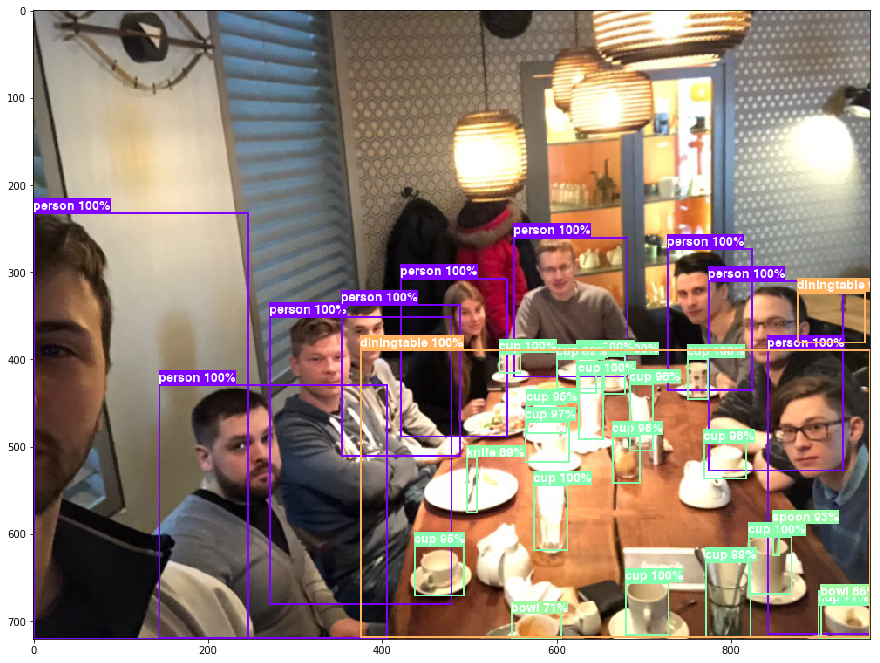

In [2]:
from matplotlib import pyplot as plt
import cv2
import torch


from utils import predict_and_save
%matplotlib inline

model = Darknet('./cfg/yolov3_608x608.cfg')
weight_file = './weights/yolov3.weights'
model.load_weights(weight_file)
model.eval();

device = torch.device('cpu')
labels_path='./data/coco.names'
# img_path = 'dog-cycle-car.png'
img_path = 'databreakfast_spb.jpg'
# img_path = './Screenshot 2019-07-30 at 21.52.27.jpg'
# img_path = 'NvFAv2v.png'
# img_path = 'typical_russian_morning.jpg'
save_path = './output.jpg'
show = True

img_raw = cv2.imread(img_path)
img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
print(img_path)
print(img_raw.shape)

# add letterbox padding and save the pad sizes and scalling coefficient
# to use it latter when drawing bboxes on the original image
H, W, C = img_raw.shape
H_new, W_new, scale = scale_numbers(H, W, model.model_width)
img = cv2.resize(img_raw, (W_new, H_new))
img, pad_sizes = letterbox_pad(img)

# HWC -> CHW, scale intensities to [0, 1], send to pytorch, add 'batch-'dimension
img = img.transpose((2, 0, 1))
img = img / 255
img = torch.from_numpy(img).float()
img = img.unsqueeze(0)

prediction = model(img, device=device)
# (76 x 76 + 38 x 38 + 19 x 19) * 3 = 22743
prediction = predict_and_save(img_path, save_path, model, device, labels_path, show)

In [44]:
from matplotlib import cm as colormap
for i in range(80):
    print(colormap.rainbow(i/80))

(0.5, 0.0, 1.0, 1.0)
(0.4764705882352941, 0.03695149938914489, 0.9998292504580527, 1.0)
(0.45294117647058824, 0.07385252747487396, 0.9993170601430229, 1.0)
(0.4294117647058824, 0.11065268189150083, 0.9984636039674339, 1.0)
(0.40588235294117647, 0.1473016980546375, 0.997269173385788, 1.0)
(0.37450980392156863, 0.19584546700716696, 0.9951469164070644, 1.0)
(0.3509803921568627, 0.23194764145389815, 0.9931586661366362, 1.0)
(0.32745098039215687, 0.2677330033224679, 0.9908312530915603, 1.0)
(0.303921568627451, 0.30315267411304353, 0.9881654720812594, 1.0)
(0.2803921568627451, 0.33815827481581706, 0.9851622334675065, 1.0)
(0.24901960784313726, 0.38410574917192586, 0.9806347704689777, 1.0)
(0.22549019607843135, 0.41796034488678346, 0.9768483177596007, 1.0)
(0.2019607843137255, 0.45124405704532283, 0.9727282722446048, 1.0)
(0.17843137254901964, 0.4839114241003015, 0.9682760409157589, 1.0)
(0.15490196078431373, 0.5159178263577511, 0.9634931442059831, 1.0)
(0.12352941176470589, 0.557489439342885